#   Challenge Exoplanet Detection


### Step 0: imports

In [ ]:
# Run this once to install a python package for downloading lightcurves from the TESS mission
# ! python -m pip install lightkurve --upgrade

In [ ]:
# these should be familar
import scipy
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# this package will allow us to make progress bars
from tqdm import tqdm

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['font.family'] = "serif"

# Step 1: loading data from the TESS mission


Like the last notebook, the function below uses the python package `lightkurve` to load data from the TESS mission. To search for exoplanets, TESS takes pictures of a patch of the sky once every 2 minutes. The function `load_TESS_data` takes in the name of a star and the size of image cutout we want to downdload (centered on the star).

**Exercise:** Run the code below to load in the functions we used in the last notebook.

In [ ]:
# this function downloades TESS lightcurves (I recommend we supply this function
# and have the student's use it as a black box)

def load_TESS_data(target, cutout_size=20, verbose=False, exptime=None):
    """
    Download TESS images for a given target.

    inputs:
        target: str, same of star (ex. TOI-700)
        cutout_size: int, size of the returned cutout
                     (in units of pixels)
        verbose: bool, controls whether to include printouts
        exptime: str, determines if we use short or long cadence mode
                 (if None, defaults to first observing semester)
    outputs:
        time: numpy 1D array
        flux: numpy 3D array (time x cutout_size x cutout_size)
    """

    import lightkurve as lk

    # find all available data
    search_result = lk.search_tesscut(target)
    if exptime == 'short':
        search_result = search_result[search_result.exptime.value==search_result.exptime.value.min()]
    elif exptime == 'long':
        search_result = search_result[search_result.exptime.value==search_result.exptime.value.max()]
    print(search_result)

    # select the first available observing sector
    if exptime:
        search_result = search_result[search_result.exptime == exptime]
    search_result = search_result[search_result.mission == search_result.mission[0]]

    # download it
    tpf = search_result.download_all(cutout_size=cutout_size)[0]

    # convert it to a numpy array format
    flux = np.array([
        tpf.flux[i].value for i in range(len(tpf.flux)) if tpf.flux[i].value.min()>0
    ])
    flux_err = np.array([
        tpf.flux_err[i].value for i in range(len(tpf.flux_err)) if tpf.flux[i].value.min()>0
    ])

    time = np.array([
        tpf.time.value[i] for i in range(len(tpf.flux)) if tpf.flux[i].value.min()>0
                    ])

    return time, flux, flux_err

In [ ]:
def plot_cutout(image, logscale = False, vrange = [1,99]):
    """
    Plot 2D image.

    inputs:
        image: 2D numpy array
        logscale: bool, if True plots np.log10(image)
        vrnge: list, sets range of colorbar
               (based on percentiles of 'image')
    """
    if logscale:
        image = np.log10(image)

    q = np.percentile(image, q = vrange)
    plt.imshow( image, vmin = q[0], vmax = q[1] )
    plt.show()

def psf(x,y,sigma,scale,bkg,xmu=0,ymu=0,unravel=False):
    """
    Symmetric 2D point-spread function (PSF)

    inputs:
        x: np.ndarray, where to evaluate the PSF
        y: np.ndarray, where to evaluate the PSF
        sigma: float, width of the PDF
        scale: float, integrated area under the PSF
        bkg: float, background flux level
        xmu: float, center of PSF in x
        ymu: float, center of PSF in y
    outputs:
        PSF evalauted at x and y
    """
    exponent = (np.power(x-xmu,2) + np.power(y-ymu,2) ) / sigma**2

    mod = scale * np.exp(-exponent) / (2*np.pi*sigma**2) + bkg
    if unravel:
        return mod.ravel()
    else:
        return mod

def residual(theta, x, y, z, z_err):
    sigma, scale, bkg, xmu, ymu = theta

    model = psf(x,y,sigma=sigma,scale=scale,bkg=bkg,xmu=xmu,ymu=ymu)

    chi = np.power(model - z,2)/z_err**2

    return np.sum(chi)

def median_filter(x,y,width):
    smooth = []
    for xi in x:
        C = np.abs(xi-x)<width/2
        smooth.append(np.median(y[C]))
    return np.array(smooth)

def phase_it(x,y,period):
    x_phased = (x/period)%1
    y_phased = y[np.argsort(x_phased)]

    return x_phased[np.argsort(x_phased)], y_phased

**Exercise:** Run the code below to load all the TESS data for one small patch of the sky. We'll center our images on the same variable star from the last notebook.

Do you find evidence of a planet? if so, at what orbital period? Can you determine the radius of the planet?

For reference, the star's radius is 0.90 solar radii.

In [ ]:
target = 'TOI-132'
cutout_size = 20 # dimensions of the image in pixels x pixels
time, flux, flux_err = load_TESS_data(target,verbose=True,cutout_size=cutout_size,exptime=1426)

SearchResult containing 3 data products.

 #     mission     year  author exptime target_name distance
                                   s                 arcsec 
--- -------------- ---- ------- ------- ----------- --------
  0 TESS Sector 01 2018 TESScut    1426     TOI-132      0.0
  1 TESS Sector 28 2020 TESScut     475     TOI-132      0.0
  2 TESS Sector 68 2023 TESScut     158     TOI-132      0.0


In [ ]:
# where to evaluate our PSF
x = np.arange(flux.shape[1])
y = np.arange(flux.shape[2])
X,Y = np.meshgrid(x,y)

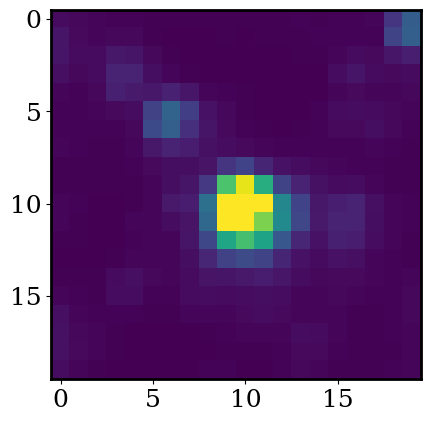

In [ ]:
# linear scale
plot_cutout(np.mean(flux,axis=0),logscale=True)